In [1]:
import logging
import pickle
import numpy as np 
import matplotlib.pyplot as plt 
import sys

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import cross_validation 
from sklearn.naive_bayes import GaussianNB 
from sklearn.datasets import load_digits 
from sklearn.learning_curve import learning_curve 
from sklearn.cross_validation import ShuffleSplit, train_test_split 
from sklearn.grid_search import GridSearchCV




/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Users/dsluis/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.

In [2]:
from sellibrary.gbrt import GBRTWrapper
from sellibrary.text_file_loader import load_feature_matrix
from sellibrary.filter_only_golden import FilterGolden
from sellibrary.locations import FileLocations
from sellibrary.wiki.wikipedia_datasets import WikipediaDataset
from sellibrary.sel.dexter_dataset import DatasetDexter

from sellibrary.util.test_train_splitter import DataSplitter

INTERMEDIATE_PATH = FileLocations.get_dropbox_intermediate_path()

In [3]:
# setup logging


handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s'))
logger = logging.getLogger(__name__)
logger.addHandler(handler)
logger.propagate = False
logger.setLevel(logging.INFO)



In [4]:


def get_r2_train_model(filename, number_features_per_line, feature_names):


    X, y, docid_array, entity_id_array = load_feature_matrix(feature_filename=INTERMEDIATE_PATH + filename,
                                                             feature_names=feature_names,
                                                             entity_id_index=1,
                                                             y_feature_index=2, 
                                                             first_feature_index=4, 
                                                             number_features_per_line=number_features_per_line,
                                                             tmp_filename='/tmp/temp_conversion_file.txt'
                                                             )
    
    # train only on records we have a golden salience for
    fg = FilterGolden()
    logger.info('X Shape = %s',X.shape)
    logger.info('y Shape = %s',y.shape)
    
    dexter_dataset = DatasetDexter()
    wikipedia_dataset = WikipediaDataset()

    X2, y2, docid2, entityid2 = fg.get_only_golden_rows(X, y, docid_array, entity_id_array, dexter_dataset, wikipedia_dataset )

#     X2, y2, docid2, entityid2 = fg.get_only_golden_rows(X, y, docid_array, entity_id_array)

    
    
    wrapper = GBRTWrapper()
    gbrt = wrapper.train_model_no_split(X2, y2,  n_estimators=40)
    logger.info('trained')
    #gbrt.save_model()

    # from https://shankarmsy.github.io/stories/gbrt-sklearn.html
    #One of the benefits of growing trees is that we can understand how important each of the features are 
    print ("Feature Importances" )
    print (gbrt.feature_importances_) 
    print ()
    #Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is 
    #able to decipher. 
    print ("R-squared for Train: %.2f" %gbrt.score(X2, y2) )
    #print ("R-squared for Test: %.2f" %gbrt.score(X_test, y_test) )
    #- See more at: https://shankarmsy.github.io/stories/gbrt-sklearn.html#sthash.JNZQbnph.dpuf
    return gbrt, X2, y2, docid2, entityid2
    




In [5]:

#All right let's do this the right way. We'll use a cross-validation generator to 
# select train and CV datasets to finetune parameters such as C 
# (Regularization parameter we saw earlier). These hyperparameters are extremely critical to 
# the model. 
#Now, if we tune parameters against the Test dataset, we will end up biasing towards the test 
# set and will once again not generalize very well. We will also have no good way to find out 
# since we have essentially trained on all our data. 
#Luckily scikit-learn has builit-in packages that can help with this. We'll use a crossvalidation 
# generator that can train the model by tuning the parameters based on a cross-validation subset 
# (cv) that is picked from within the training set. A different cv subset will be picked for each iteration, we control the number of iterations. Then we will 
#use these cv/train splits and run a gridsearch function that will evaluate the model with each split and tune parameters 
#to give us the best parameter that gives the optimal result.

#Defining this as a function so we can call it anytime we want



def GradientBooster(param_grid, n_jobs, X, y, estimator):
    
    #Choose cross-validation generator - let's choose ShuffleSplit which randomly shuffles and selects Train and CV sets 
    #for each iteration. There are other methods like the KFold split.
    cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2)
    #Apply the cross-validation iterator on the Training set using GridSearchCV. This will run the classifier on the 
    #different train/cv splits using parameters specified and return the model that has the best results 

    # 
    #Note that we are tuning based on the F1 score 2PR/P+R where P is Precision and R is Recall. This may not always be 
    #the best score to tune our model on.  For now, we'll use F1.
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    #Also note that we're feeding multiple neighbors to the GridSearch to try out. 
    #We'll now fit the training dataset to this classifier
    classifier.fit(X, y)
    #Let's look at the best estimator that was found by GridSearchCV
    print ("Best Estimator learned through GridSearch")
    print ( classifier.best_estimator_)
    return cv, classifier.best_estimator_, classifier
    


In [6]:
def get_num_jobs():
    if sys.platform == 'win32':
        return 8
    else:
        if sys.platform == 'linux': # Sherlock ML
            return 8
        else:
            return 4 # mac

In [43]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)): 
    
    """ Generate a simple plot of the test and traning learning curve. 
    Parameters ---------- 
    estimator : object type that implements the "fit" and "predict" methods An object of that type which is cloned for each validation. 
    title : string Title for the chart. 
    X : array-like, shape (n_samples, n_features) Training vector, where n_samples is the number of samples and n_features is the number of features. 
    y : array-like, shape (n_samples) or (n_samples, n_features), optional Target relative to X for classification or regression; None for unsupervised learning. 
    ylim : tuple, shape (ymin, ymax), optional Defines minimum and maximum yvalues plotted. 
    cv : integer, cross-validation generator, optional If an integer is passed, it is the number of folds (defaults to 3). Specific cross-validation objects can be passed, see sklearn.cross_validation module for the list of possible objects 
    n_jobs : integer, optional Number of jobs to run in parallel (default 1). """ 
    fig = plt.figure()
    plt.title(title)
    if ylim is not None: plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt, fig
                  

In [8]:
def print_info(best_est, X, y, tset):
    print ("--------------------------------" )
    print (tset+" Best Estimator Parameters" )
    print ("--------------------------------" )
    print ("n_estimators: %d" %best_est.n_estimators )
    print ("max_depth: %d" %best_est.max_depth )
    print ("min_samples_leaf: %d" %best_est.min_samples_leaf )
    print ("max_features: %.2f" %best_est.max_features )
    print (tset+" R-squared: %.2f" %best_est.score(X,y) )     
    print ("Learning Rate: %.2f" %best_est.learning_rate )

 

In [9]:

def perform_grid_search(X,y):

    # if no space left on device, try setting the env ver JOBLIB_TEMP_FOLDER to /tmp
    %env JOBLIB_TEMP_FOLDER=/tmp
    #WARNING - THIS MIGHT TAKE A WHILE TO RUN. 
    # TRY ADJUSTING parameters such as n_jobs (jobs to run in parallel, before 
    #increasing this make sure your system can handle it), n_iter for ShuffleSplit 
    # (in the function definition) and reducing #number of values being tried for max_depth/n_estimators. 
    #SELECT INTERRUPT IN THE MENU AND PRESS INTERRUPT KERNEL IF YOU NEEDD TO STOP EXECUTION 
    logger.info('starting')

    param_grid={'n_estimators':[450, 500, 550], # tried 250, 100, [50], 25
                'learning_rate': [0.02, 0.01, 0.005],# tried 0.2, 0.1, [0.05], 0.02, 0.01],
                'max_depth':[7, 9, 12], # tried 6,[9],12
                'min_samples_leaf':[18, 20, 22], # tried  2,5,9,12,15,[18]
                'max_features':[0.2,0.3,0.4] # tried 0.2,[0.3],0.4,0.5
               } 
    n_jobs = get_num_jobs() 

    #Let's fit GBRT to the digits training dataset by calling the function we just created. 
    estimator = GradientBoostingRegressor()

    cv, best_est, trained_model=GradientBooster(param_grid, n_jobs, X, y, estimator) 
    logger.info('complete')
    print_info(best_est, X, y, '.8CV')
    
    return cv, best_est


            

# Load Data

In [29]:
light_feature_names = [
    'min_normalised_position',  # 1
    'max_normalised_position',  # 1
    'mean_normalised_position',  # 1
    'normalised_position_std_dev',  # 1
    'norm_first_position_within_first 3 sentences',  # 2
    'norm first positon within body middle',  # 2
    'norm_first_position_within last 3 sentences',  # 2
    'normed first position within title',  # 2
    'averaged normed position within sentences',  # 3
    'freq in first 3 sentences of body ',  # 4
    'freq in middle of body ',  # 4
    'freq in last 3 sentences of body ',  # 4
    'freq in title ',  # 4
    'one occurrence capitalised',  # 5
    'maximum fraction of uppercase letters',  # 6
    'average spot length in words',  # 8.1 :
    'average spot length in characters',  # 8.2 :
    'is in title',  # 11 :
    'unambiguous entity frequency',  # 14 : 1 entity frequency feature
    'entity in_degree in wikipeada',  # 20 :
    'entity out_degree in wikipeada',  # 20 :
    'entity degree in wikipeada',  # 20 :
    'document length',  # 22 :
]

heavy_feature_names = [
    'v1_graph_size', 'v1_graph_diameter', 'v1_node_degree', 'v1_degree_mean_median_ratio',
    'v1_out_degree_mean_median_ratio', 'v1_degree_mean_median_ratio', 'v1_farness', 'v1_closeness', 'v1_centrality',
    'v1_minus_low_relatedness_graph_size', 'v1_minus_low_relatedness_graph_diameter',
    'v1_minus_low_relatedness_node_degree', 'v1_minus_low_relatedness_degree_mean_median_ratio',
    'v1_minus_low_relatedness_out_degree_mean_median_ratio', 'v1_minus_low_relatedness_degree_mean_median_ratio',
    'v1_minus_low_relatedness_farness', 'v1_minus_low_relatedness_closeness',
    'v1_minus_low_relatedness_centrality', 'v0_graph_size', 'v0_graph_diameter', 'v0_node_degree',
    'v0_degree_mean_median_ratio', 'v0_out_degree_mean_median_ratio', 'v0_degree_mean_median_ratio', 'v0_farness',
    'v0_closeness', 'v0_centrality', 'v0_minus_low_relatedness_graph_size',
    'v0_minus_low_relatedness_graph_diameter', 'v0_minus_low_relatedness_node_degree',
    'v0_minus_low_relatedness_degree_mean_median_ratio', 'v0_minus_low_relatedness_out_degree_mean_median_ratio',
    'v0_minus_low_relatedness_degree_mean_median_ratio', 'v0_minus_low_relatedness_farness',
    'v0_minus_low_relatedness_closeness', 'v0_minus_low_relatedness_centrality'
]

all_feature_names = light_feature_names
all_feature_names.extend(heavy_feature_names)

X_sel, y_sel, docid_array_sel, entity_id_array_sel = load_feature_matrix(
    feature_filename=INTERMEDIATE_PATH+'aws/all.txt',
    feature_names=all_feature_names,
    entity_id_index=1,
    y_feature_index=2, first_feature_index=4, number_features_per_line=len(all_feature_names) + 4,
    tmp_filename='/tmp/temp_conversion_file.txt'
    )

# remove any rows that are not in the golden set
dexterDataset = DatasetDexter()
wikipediaDataset = WikipediaDataset()
fg = FilterGolden()
X_sel, y_sel, docid_array_sel, entity_id_array_sel = fg.get_only_golden_rows(X_sel, y_sel, docid_array_sel, entity_id_array_sel, dexterDataset, wikipediaDataset)
logger.info('After filtering only golden rows:')
logger.info('X Shape = %s', X_sel.shape)
logger.info('y Shape = %s', y_sel.shape)

# set sentiment to a binary classifier
# y_sel[y_sel < 2.0] = 0
# y_sel [y_sel >= 2.0] = 1


2018-07-23 09:43:53,137 sellibrary.text_file_loader INFO     loading data from : /Users/dsluis/Dropbox/Datasets/intermediate/aws/all.txt
2018-07-23 09:43:54,108 sellibrary.text_file_loader INFO     10000 lines processed
2018-07-23 09:43:54,177 sellibrary.text_file_loader INFO     20000 lines processed
2018-07-23 09:43:54,295 sellibrary.text_file_loader INFO     30000 lines processed
2018-07-23 09:43:54,354 sellibrary.text_file_loader INFO     40000 lines processed
2018-07-23 09:43:54,415 sellibrary.text_file_loader INFO     50000 lines processed
2018-07-23 09:43:54,469 sellibrary.text_file_loader INFO     60000 lines processed
2018-07-23 09:43:54,472 sellibrary.text_file_loader INFO     skipping line with 125 rather than 63 fields "26,716712,0,0,[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 741, 2.0, 2, 0, 1.0539811066126856, 2.1079622132253713, 2.0, 0.5, 1, 633, 2.0, 2, 0, 1.0442338072669826, 2.088467614533965, 2.0, 0.5, 1, 0, 0, 0, nan, nan, nan, 0, 0, 0, 0, 0

# Save data to pickle

In [30]:


output_filename = INTERMEDIATE_PATH+'SEL_dataset.pickle'
sel_dict = {"X":X_sel, "y":y_sel, "docid": docid_array_sel, "entity_id": entity_id_array_sel}
with open(output_filename, 'wb') as handle:
     pickle.dump(sel_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


        
        
        

# Load Data from pickle

In [ ]:

# import os
# input_filename =  INTERMEDIATE_PATH + 'SEL_dataset.pickle'
# if os.path.isfile(input_filename):
#     logger.info('loading data from %s', input_filename)
#     with open(input_filename, 'rb') as handle:
#         sel_dict = pickle.load(handle)      
#         X_sel = sel_dict["X"]
#         y_sel = sel_dict["y"]
#         docid_array_sel = sel_dict["docid"]
#         entity_id_array_sel = sel_dict["entity_id"]
        
#     logger.info('loaded')
    
    

# Perform Grid Search for Hyper Parameters

In [18]:
cv, best_est = perform_grid_search(X_sel,y_sel)

2018-07-21 18:12:21,831 __main__     INFO     starting


env: JOBLIB_TEMP_FOLDER=/tmp


2018-07-21 18:33:25,649 __main__     INFO     complete


Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=7, max_features=0.2,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=22,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)
--------------------------------
.8CV Best Estimator Parameters
--------------------------------
n_estimators: 500
max_depth: 7
min_samples_leaf: 22
max_features: 0.20
.8CV R-squared: 0.79
Learning Rate: 0.01



# Plot Learning Curve - How much data we need
   

2018-07-23 10:48:17,402 __main__     INFO     starting


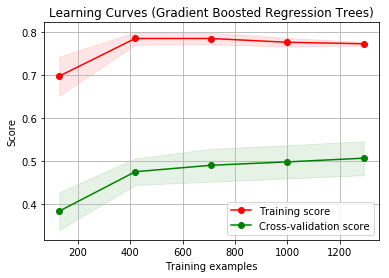

2018-07-23 10:48:44,748 __main__     INFO     complete


In [47]:
#OK we'll now call the plot_learning_curve module by feeding it the estimator (best estimator returned from GS) 
#and train/cv sets. 
#The module simply runs the estimator multiple times on subsets of the data provided and plots the train and cv scores. 
#Note that we're feeding the best parameters we've learned from GridSearchCV to the estimator now. 
#We may need to adjust the hyperparameters further if there is overfitting (or underfitting, though unlikely) 

logger.info('starting')
title = "Learning Curves (Gradient Boosted Regression Trees)" 
n_jobs = get_num_jobs()
gbr_estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, 
                                      max_depth=best_est.max_depth, 
                                      learning_rate=best_est.learning_rate, 
                                      min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features) 
plt, fig = plot_learning_curve(gbr_estimator, title, X_sel, y_sel, cv=cv, n_jobs=n_jobs) 

plt.show() 
GRAPH_PATH = '/Users/dsluis/Dropbox/UCL/UCL - Business Analytics specialisation in Computer Science/T3-COMPG099 - Dissertation/Diagrams/'
fig.savefig(GRAPH_PATH+'Learning_curve_GBRT.png')
logger.info('complete')

# R-squared revers to the proportion of variation in data that can be explained by our model. 
# 1.0 is perfect, 0.05 not very useful
# Distance between train and cross validation = 
# Gradient suggest whether more training data is useful
# How does the number of estimators affect the curve?




# Split Data - to train real model

In [37]:
splitter = DataSplitter()
X_train, X_test, y_train, y_test, in_train_set_by_id = splitter.get_test_train_datasets(X_sel,y_sel,docid_array_sel,7,train_split=0.50)



In [38]:
print(X_train.shape)
print(X_test.shape)

(2004, 59)
(1861, 59)


In [56]:
in_train_set_by_id

ids_in_trainset = []
ids_in_testset = []
for i in in_train_set_by_id.keys():
    if in_train_set_by_id[i]:
        ids_in_trainset.append(int(i))
    else:
        ids_in_testset.append(int(i))
        
len(ids_in_trainset)
s = str(ids_in_trainset)
s = s.replace(' ','').replace('[','').replace(']','')
print('Trainset\n'+s)
print('Length:'+str(len(ids_in_trainset)))


len(ids_in_testset)
s = str(ids_in_testset)
s = s.replace(' ','').replace('[','').replace(']','')
print('Testset\n'+s)
print('Length:'+str(len(ids_in_testset)))


    

Trainset
1,2,4,6,7,9,10,11,12,13,16,17,22,24,26,27,28,29,31,34,36,37,38,40,41,43,44,49,54,56,57,60,62,63,71,75,78,81,86,87,89,90,91,93,94,96,98,99,101,103,108,109,110,113,114,115,116,118,123,124,125,126,136,141,144,145,148,149,150,151,153,154,155,156,157,158,159,162,163,165,166,167,170,171,172,173,174,175,178,180,183,185,190,191,192,196,197,205,207,208,209,210,211,214,218,219,221,222,223,227,230,236,237,239,243,244,247,248,249,252,256,258,259,264,267,268,269,270,272,273,274,276,277,280,285,288,290,291,293,294,298,302,304,305,313,318,320,326,331,332,333,334,336,337,341,532,538,541,542,546,548,551,553,555,561,566,567,568,571,575,576,577,579,580,582,587,588,593,594,596,597,601,603
Length:183
Testset
3,5,8,14,18,20,21,23,25,30,32,33,35,39,42,45,46,50,51,52,53,55,58,64,66,68,70,72,73,74,76,77,80,82,83,84,85,88,95,100,104,105,106,107,111,112,119,127,129,131,132,133,134,137,138,139,140,146,160,161,168,169,177,181,182,184,186,187,188,189,193,194,195,198,199,200,202,203,204,206,212,213,215,216,

In [50]:
gbr_estimator.fit(X_train,y_train)
print ("Feature Importances" )
print (gbr_estimator.feature_importances_) 
print ()
#Let's print the R-squared value for train/test. This explains how much of the variance in the data our model is 
#able to decipher. 
print ("R-squared for Train: %.2f" %gbr_estimator.score(X_test, y_test) )





Feature Importances
[ 0.09410583  0.03896216  0.0410011   0.02237894  0.04104831  0.01982013
  0.00641015  0.02739751  0.03144776  0.03964829  0.00941675  0.00189437
  0.08160791  0.          0.02248566  0.01130819  0.03256522  0.
  0.02331491  0.01177357  0.01985515  0.02128245  0.05215933  0.03440074
  0.00394308  0.01905097  0.01352031  0.01539162  0.02348947  0.02979972
  0.02648647  0.          0.02984903  0.0022995   0.02069068  0.01043718
  0.0174978   0.02613859  0.01872812  0.02164845  0.          0.00343221
  0.00135549  0.00235792  0.00155545  0.00333118  0.00571725  0.00200692
  0.00297599  0.00186071  0.00320891  0.00064341  0.00033096  0.00046638
  0.00246532  0.00395372  0.00027906  0.00063104  0.00017266]

R-squared for Train: 0.53


In [51]:

a = np.ones([1,59])
gbr_estimator.predict(a)[0]

1.6497055073108036

# Save Model

In [52]:
output_filename = INTERMEDIATE_PATH+'sel_golden_spotter_GradientBoostingRegressor.pickle'
with open(output_filename, 'wb') as handle:
     pickle.dump(gbr_estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [48]:
gbr_estimator

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=7, max_features=0.2,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=22,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)